<a href="https://colab.research.google.com/github/moonisali/ADFB_SpringerNature/blob/master/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Task2 *(parts)*

*   
*   



# Hindi Hatespeech classification with Bi_LSTM

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1eJvipWVk9aemObY00dYqUFLkBPFlogze#scrollTo=AfN3bMR5Gw-o"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [560]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools as it
import spacy
from spacy.lang.hi import Hindi
nlp_hi = Hindi()
import regex as re
!pip install demoji
import demoji
demoji.download_codes()
!pip install emot
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
tfds.disable_progress_bar()

... OK (Got response in 0.15 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [561]:
seed_value = 0

np.random.seed(seed_value)
#tf.set_random_seed(seed_value)

Import `matplotlib` and create a helper function to plot graphs:

In [562]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


---write



In [563]:
fields = ['text', 'task_1']

data_set = pd.read_csv("hindi_hatespeech.tsv", sep='\t', skipinitialspace=True, usecols=fields)
print(data_set.head())
stop_words = open("stop_word_hindi.txt","r")
stopword_list = stop_words.readlines()
stop_words.close()
converted_list = []
for element in stopword_list:
    converted_list.append(element.strip())
print(converted_list)

for stopword in stopword_list:
    lexeme = nlp_hi.vocab[stopword]
    lexeme.is_stop = True







                                                text task_1
0  बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...    NOT
1  सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...    HOF
2  तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...    HOF
3  बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...    NOT
4  चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...    NOT
['अंदर', 'अत', 'अदि', 'अप', 'अपना', 'अपनि', 'अपनी', 'अपने', 'अभि', 'अभी', 'आदि', 'आप', 'इंहिं', 'इंहें', 'इंहों', 'इतयादि', 'इत्यादि', 'इन', 'इनका', 'इन्हीं', 'इन्हें', 'इन्हों', 'इस', 'इसका', 'इसकि', 'इसकी', 'इसके', 'इसमें', 'इसि', 'इसी', 'इसे', 'उंहिं', 'उंहें', 'उंहों', 'उन', 'उनका', 'उनकि', 'उनकी', 'उनके', 'उनको', 'उन्हीं', 'उन्हें', 'उन्हों', 'उस', 'उसके', 'उसि', 'उसी', 'उसे', 'एक', 'एवं', 'एस', 'एसे', 'ऐसे', 'ओर', 'और', 'कइ', 'कई', 'कर', 'करता', 'करते', 'करना', 'करने', 'करें', 'कहते', 'कहा', 'का', 'काफि', 'काफ़ी', 'कि', 'किंहें', 'किंहों', 'कितना', 'किन्हें', 'किन्हों', 'किया', 'किर', 'किस', 'किसि', 'किसी', 'किसे', 'की', 'कुछ',

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


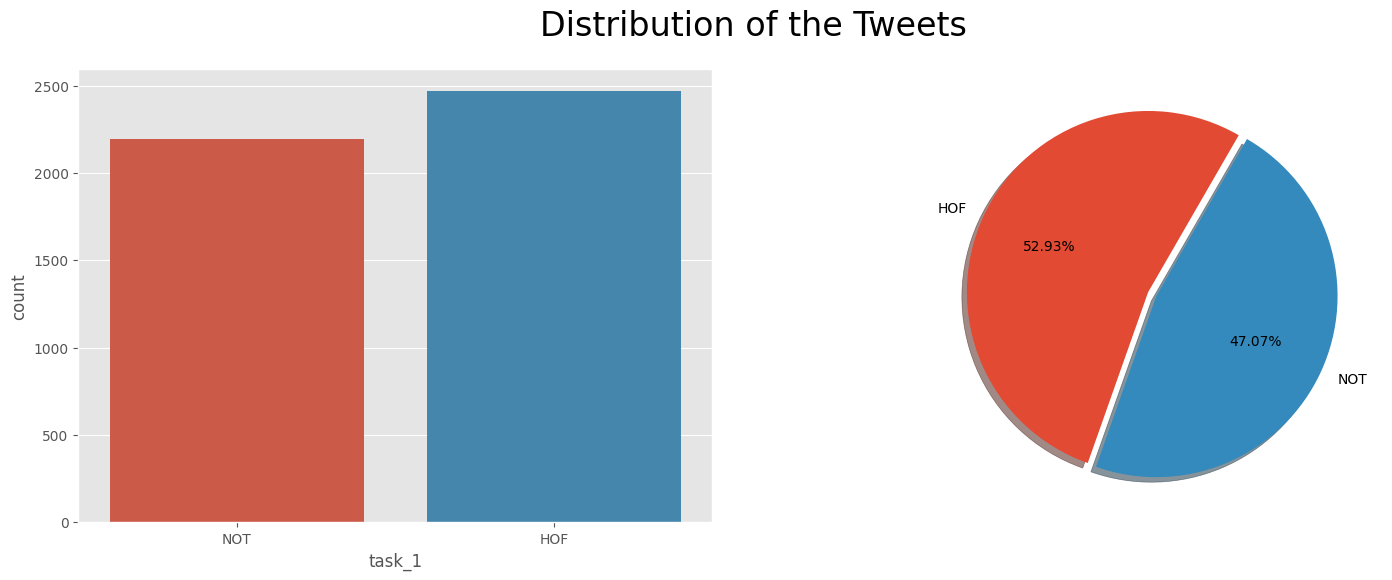

In [564]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(data_set['task_1'], ax=axes[0])
axes[1].pie(data_set['task_1'].value_counts(),
            labels=['HOF', 'NOT'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()



In [565]:
def preprocessing_hi(tweet):
  tweet_hi = []
  
  tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
  tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc
  tweet = re.sub('#\S+', '', tweet)  # remove hashtags
  tweet = re.sub('@\S+', '', tweet)  # remove mentions
  tweet = demoji.replace(tweet," ") #remove smoji's
  tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', tweet)  # remove punctuations
  #tweet = re.sub(r'[+-]?([0-9]*[.])?[0-9]+', ' ', tweet) #<------------------------------- DABJER ****************
  tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
  
  tweet = tweet.lower()
    
  # ******* the following piece shall check for hindi specific text-preprocessing using spacy.hindi. lan. library ***** 
  # ******* as well as catches exception from previous block **********************************************************  
  
  tokenized_text = nlp_hi(tweet)
  for token in tokenized_text:
    if(token.text!='\n\n' 
      and (re.search('#\S+',token.text)is None)
      and (re.search(r'@\S+',token.text) is None)
      and not token.is_stop 
      and not token.is_punct 
      and not token.is_space 
      and not token.like_email
      and not token.is_digit
      and not token.is_quote
      and not token.like_url):
     tweet_hi.append(token.lemma_)
  
  
  tweet = ' '.join([token  for token in tweet_hi])
   
  return tweet

cleaned_tweets = []
for t in data_set.text:
  cleaned_tweets.append(preprocessing_hi(t))

Cleaned_Tweet_df = pd.DataFrame(cleaned_tweets, columns = ['cleaned_tweets'])

print(Cleaned_Tweet_df)
print(data_set)

data_set['text'] = Cleaned_Tweet_df['cleaned_tweets'].str.replace(',','-')
data_set = data_set.rename(columns = {'task_1': 'label'}, inplace = False)

print(data_set.head())
#data_set.label = pd.Categorical(data_set.label)
#data_set['code'] = data_set.label.cat.codes #to change from categorical to binary value 0/1
#data_set.head()


#data_set['code'] = 1 - data_set['code'] #to make nothate 0 and hate as 1 //before it was inverted

#data_set = data_set.drop(columns="label") # remove previous column of categories HOF and NOT
#data_set = data_set.rename(columns = {'code': 'label'}, inplace = False) 

#data_set.head()


#train_dataset, test_dataset = dataset['train'], dataset['test']

#train_dataset.element_spec 

                                         cleaned_tweets
0                  बांग्लादेश शानदार वापसी भारत रन रोका
1           सब रंडी नाच देखने व्यस्त होगा सब शुरू देंगे
2     तुम हरामियों बस जूतों कमी शुक्र तुम्हारी लिंचि...
3     बीजेपी mla आकाश विजयवर्गीय जेल रिहा जमानत मिलन...
4     चमकी बुखार विधानसभा परिसर आरजेडी प्रदर्शन तेजस...
...                                                 ...
4660  पाकिस्तान हिंदुओं ख़िलाफ़ बोलने बर्खास्त क्या ...
4661          कोहली अंग्रेजों तलवे चाटने लगे भड़वा साला
4662                    परशुराम वही जिसने मां हत्या थीं
4663  देश पढ़ा लिखा युवा हार जाए जीत जाये देश जनता क्या
4664  इनके बापों दम भारत इस्लामिक स्टेट बना सकें हमा...

[4665 rows x 1 columns]
                                                   text task_1
0     बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...    NOT
1     सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...    HOF
2     तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...    HOF
3     बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function a

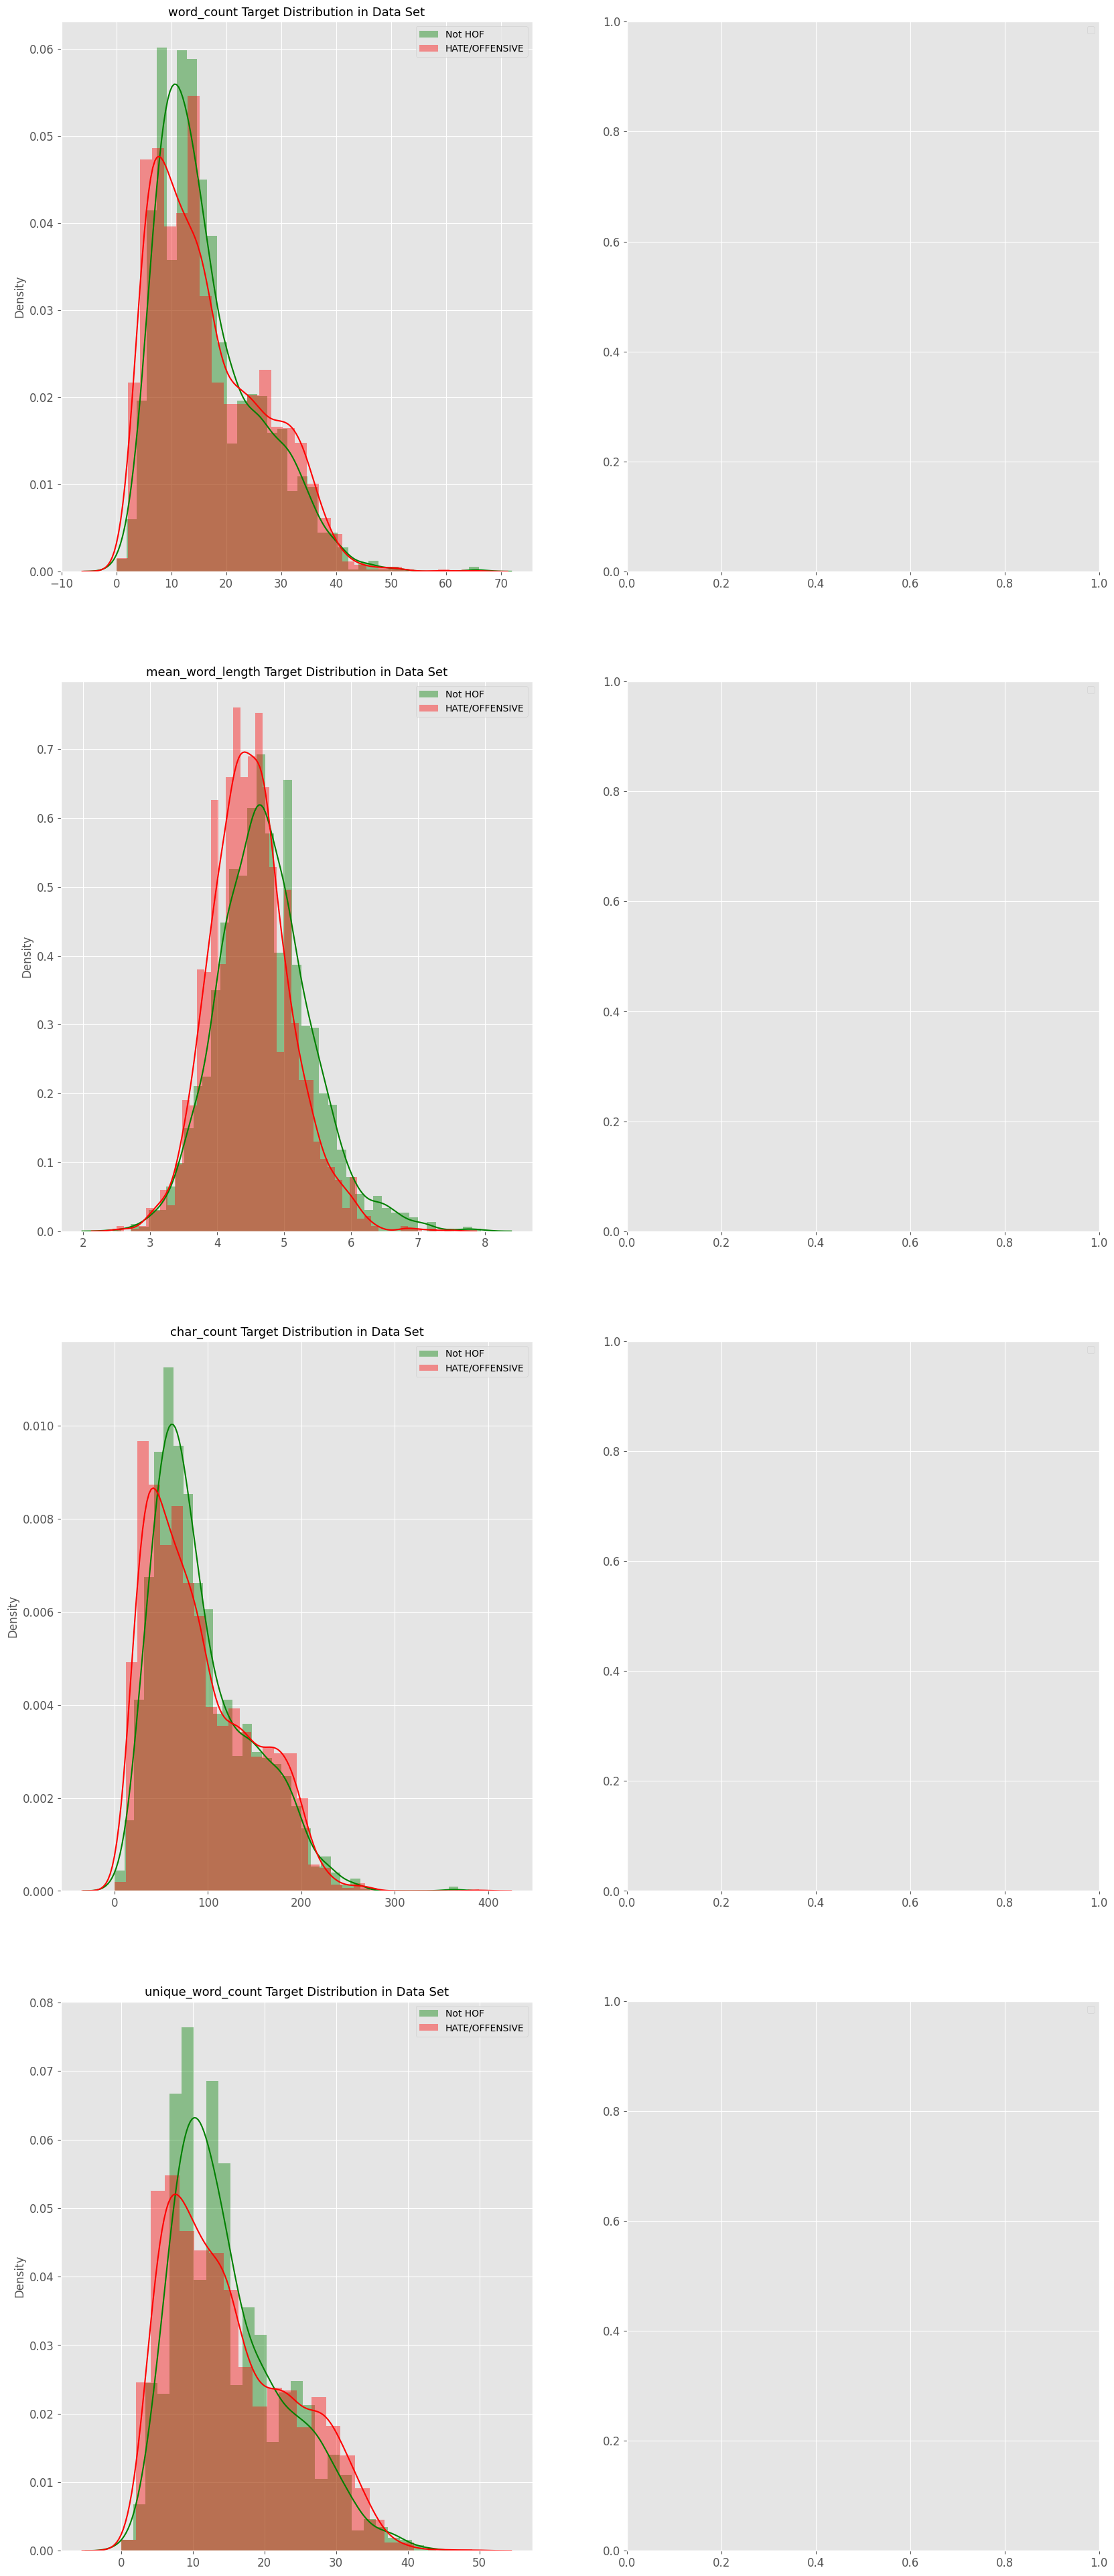

,text,label
0,बांग्लादेश शानदार वापसी भारत रन रोका,NOT
1,सब रंडी नाच देखने व्यस्त होगा सब शुरू देंगे,HOF
2,तुम हरामियों बस जूतों कमी शुक्र तुम्हारी लिंचि...,HOF
3,बीजेपी mla आकाश विजयवर्गीय जेल रिहा जमानत मिलन...,NOT
4,चमकी बुखार विधानसभा परिसर आरजेडी प्रदर्शन तेजस...,NOT


In [566]:
#Exploratory Data Analysis
import seaborn as sns
data_set['word_count'] = data_set['text'].apply(lambda x: len(str(x).split()))
data_set['unique_word_count'] = data_set['text'].apply(lambda x: len(set(str(x).split())))
data_set['char_count'] = data_set['text'].apply(lambda x: len(str(x)))
data_set['mean_word_length'] = data_set['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

METAFEATURES = ['word_count', 'mean_word_length',
                'char_count', 'unique_word_count']
TWEETS = data_set['label'] == "HOF"

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(data_set.loc[~TWEETS][feature], label='Not HOF', ax=axes[i][0], color='green')
    sns.distplot(data_set.loc[TWEETS][feature], label='HATE/OFFENSIVE', ax=axes[i][0], color='red')

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Data Set', fontsize=13)
    #axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

data_set.drop(columns=['word_count','unique_word_count','char_count', 'mean_word_length'], inplace=True)


data_set.head()

Initially this returns a dataset of (text, label pairs):

In [567]:
#data_set['label'].value_counts() //To check balance of classes
data_set.to_csv("hindi_cleaned.tsv", sep='\t',index = None, header=True)

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_set,test_size=0.2,random_state=4, shuffle=True,stratify=data_set['label'])

train_set.to_csv("trainh_cleaned.xlsv", sep='\t',index = None, header=True,encoding='utf-8')
test_set.to_csv("testh_cleaned.xlsv", sep='\t',index = None, header=True,encoding='utf-8')


In [568]:
#making vocab and working with model ---- TRAINING DATA *****************************
train = pd.read_csv("trainh_cleaned.xlsv", sep='\t')
#print(train.head())
#print("this is the information about data type in train set", train.info(verbose=True))
train_text = train['text'].astype(str)
#print(train_text)

print("TRAIN",train_text.dtype)

import keras
import tensorflow
from keras.preprocessing.text import Tokenizer
tok_all = Tokenizer(char_level=False)

tok_all.fit_on_texts(train_text)
l = tok_all.word_index
vocabulary_all= len(tok_all.word_counts)
print(vocabulary_all)


print(l)
train.head()

TRAIN object
14732
{'नही': 1, 'क्या': 2, 'देश': 3, 'जी': 4, 'वो': 5, 'अब': 6, 'हरामी': 7, 'रही': 8, 'बात': 9, 'भारत': 10, 'सब': 11, 'आज': 12, 'रंडी': 13, 'हम': 14, 'लोग': 15, 'तुम': 16, 'दिल्ली': 17, 'तू': 18, 'सरकार': 19, 'मोदी': 20, 'मंदिर': 21, 'नाम': 22, 'क्यों': 23, 'हिन्दू': 24, 'तेरे': 25, 'दे': 26, 'सुअर': 27, 'मुस्लिम': 28, 'चाहिए': 29, 'तेरी': 30, 'मादरचोद': 31, 'मीडिया': 32, 'जय': 33, 'हर': 34, 'श्री': 35, 'भड़वा': 36, 'गई': 37, 'सूअर': 38, 'साल': 39, 'ले': 40, 'गए': 41, 'आ': 42, 'दिन': 43, 'बार': 44, 'कभी': 45, 'लोगों': 46, 'to': 47, 'काम': 48, 'होगा': 49, 'साले': 50, 'the': 51, 'गांड': 52, 'hai': 53, 'भोसडीके': 54, 'वाली': 55, 'मुझे': 56, 'बोल': 57, 'भेनचोद': 58, 'जाता': 59, 'सिर्फ': 60, 'जनता': 61, 'राम': 62, 'औलाद': 63, 'मुसलमान': 64, 'चुनाव': 65, 'हमारे': 66, 'वाला': 67, 'बाप': 68, 'पार्टी': 69, 'भाजपा': 70, 'लुंड': 71, 'नेता': 72, 'पता': 73, 'दिल': 74, 'बन': 75, 'पाकिस्तान': 76, 'दी': 77, 'लिया': 78, 'धर्म': 79, 'कांग्रेस': 80, 'of': 81, 'मेरे': 82, 'इतना': 83, 'माँ': 

,text,label
0,मर्द वो उसकी हस्ती इतना रौब बगल निकले ग़र औरत ...,NOT
1,आज काँग्रेसी पुछा सही शब्द नर्क नरक मैंने कह आ...,NOT
2,संस्थाओं संविधान रक्षा करनी चाहिए भाजपा खोखला ...,HOF
3,सबूत मांगने क्या,HOF
4,दहशतगर्द औऱ पत्थरबाज जिनकी सुताई हमारे जवान जम,NOT


In [569]:
#making  label variable
from keras.utils.np_utils import to_categorical
label = train['label']
print(label[:10])
label = train.label.astype('category').cat.codes
print(label[:10])
label_twoDimension = to_categorical(label, num_classes=2,dtype='float32')
print(label_twoDimension[:10])


#training data encoding
encoded_text_train= tok_all.texts_to_sequences(train_text)
print(train_text[0])
print(encoded_text_train[0])

#training data sequencing
from keras.preprocessing import sequence
max_length = 100
padded_clean_text_train = sequence.pad_sequences(encoded_text_train, maxlen=max_length, padding='pre')




0    NOT
1    NOT
2    HOF
3    HOF
4    NOT
5    NOT
6    NOT
7    NOT
8    HOF
9    HOF
Name: label, dtype: object
0    1
1    1
2    0
3    0
4    1
5    1
6    1
7    1
8    0
9    0
dtype: int8
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
मर्द वो उसकी हस्ती इतना रौब बगल निकले ग़र औरत बेखौफ
[1447, 5, 217, 3999, 83, 6243, 2342, 747, 6244, 1039, 6245]


In [570]:
#now working on test data
test = pd.read_csv("testh_cleaned.xlsv", sep='\t')
text_test = test['text'].astype(str)

#print(text_test)


import keras
import tensorflow
from keras.preprocessing.text import Tokenizer
tok_test = Tokenizer(char_level=False)
tok_test.fit_on_texts(text_test)

print(text_test)

vocabulary_all_test = len(tok_test.word_counts)
print(vocabulary_all_test)

test_list = tok_test.word_index
print(test_list)


#making labels for test set

from keras.utils.np_utils import to_categorical
label_test = test['label']
print(label_test[:10])

label_test = test.label.astype('category').cat.codes
print(label_test[:10])
label_twoDimension_test = to_categorical(label_test, num_classes=2)

print(label_twoDimension_test[:10])


0                  मोदी बजट पेश भो श्री चुनावी जुमला फेक
1      आज बेटी बहन बलात्कार गोली मारी रही कल आपकी बार...
2      so scott morrison is also intolerant communal ...
3      अक्सर उदास लोगों हँसाता रहता क्योंकि मुझसे मुझ...
4      tumare he paale hue madarsachhap hain jo atank...
                             ...                        
928    regional parties give bjp tough fight not cong...
929    सच भड़वा गद्दार जेल क्यों नही मोदी अब जैसो सजा...
930    कानून मंत्री देवी देवताओं tv गाली देना दुर्गा ...
931                        सैम पित्रोदा काँग्रेसी हम नही
932    वर्ल्ड कप लक्ष्य पीछा उतरी बांग्लादेश मोहम्मद ...
Name: text, Length: 933, dtype: object
6349
{'नही': 1, 'क्या': 2, 'देश': 3, 'जी': 4, 'अब': 5, 'वो': 6, 'हरामी': 7, 'रही': 8, 'रंडी': 9, 'तुम': 10, 'सरकार': 11, 'तेरी': 12, 'आज': 13, 'तू': 14, 'तेरे': 15, 'हम': 16, 'दिल्ली': 17, 'भारत': 18, 'लोग': 19, 'सब': 20, 'मोदी': 21, 'दे': 22, 'मादरचोद': 23, 'मुस्लिम': 24, 'होगा': 25, 'सुअर': 26, 'जय': 27, 'श्री': 28, 'क्यों': 29, '

###After using function: 
```
from keras.utils.np_utils import to_categorical
```
####THE LABELS FINALLY BECOME:
#HOF is 0
#NOT is 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


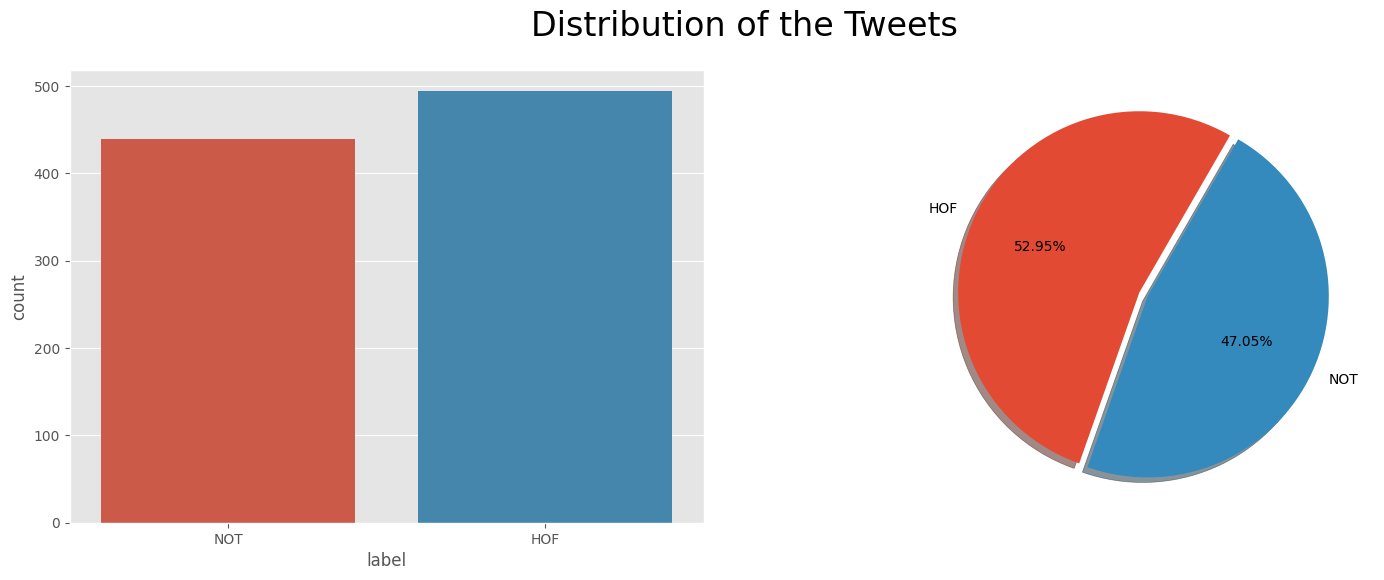

In [571]:


# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(test['label'], ax=axes[0])
axes[1].pie(test['label'].value_counts(),
            labels=['HOF', 'NOT'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()




In [572]:
##Encoding and Padding

encoded_text_test = tok_test.texts_to_sequences(text_test)
print(text_test[0])
print(encoded_text_test[0])

test.head(1)






मोदी बजट पेश भो श्री चुनावी जुमला फेक
[21, 418, 1270, 515, 28, 2245, 1271, 2246]


,text,label
0,मोदी बजट पेश भो श्री चुनावी जुमला फेक,NOT


In [573]:
#Padding the sentences to appropriate lenghts
from keras.preprocessing import sequence
max_length = 100
padded_text_test = sequence.pad_sequences(encoded_text_test, maxlen=max_length, padding='pre')

In [574]:
# Model 1 - BiLSTM


from keras.preprocessing import sequence
from keras.preprocessing import text
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM , Bidirectional
from keras.layers import Conv1D, Flatten
from keras.preprocessing import text
from keras.models import Sequential,Model
from keras.layers import Dense ,Activation,MaxPool1D,Conv1D,Flatten,Dropout,Activation,Dropout,Input,Lambda,concatenate
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
import csv
import pandas as pd

from keras.preprocessing import text as keras_text, sequence as keras_seq



In [575]:
# Model Details
Bi_lstm1_network = Sequential()
# Adding 1 Bi-Lstm layers
Embedding_Layer = Embedding(vocabulary_all+1, output_dim = 300, input_length=max_length)
#First layer(s)
Bi_lstm1_network.add(Embedding_Layer)
Bi_lstm1_network.add(Bidirectional(LSTM(128, return_sequences=True)))
Bi_lstm1_network.add(Bidirectional(LSTM(128, return_sequences=False)))
Bi_lstm1_network.add(Dropout(0.2))
# Adding Dense layer
Bi_lstm1_network.add(Dense(64,activation="relu"))
Bi_lstm1_network.add(Dropout(0.3))
Bi_lstm1_network.add(Dense(2,activation="sigmoid"))

In [576]:
Bi_lstm1_network.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 100, 300)          4419900   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 100, 256)          439296    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_95 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_133 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_96 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 2)               

In [577]:
from keras.optimizers import Adam
Bi_lstm1_network.compile(loss = "binary_crossentropy", optimizer=Adam(lr=0.00003), metrics=["accuracy"])

In [578]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1,mode='auto',
                             restore_best_weights=True) #if after 3 epochs (patience) the loss won't improve, training is stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=4, min_lr=0.00001, verbose=1,mode='auto') #if after 4 epochs (patience) the loss won't improve, lr is reduced by 0.9


#from keras.utils.vis_utils import plot_model
#plot_model(Bi_lstm1_network, to_file='BiLSTM1_model.png', show_shapes=True, show_layer_names=True)

# EMbedding should be of format .vec and  size = size of variable : (vocabulary_all) x 300.

where,  vocabulary_all is the length of the vocabulary from train set.  
> Seeds need to set, to determine that accurately.and 






In [579]:
"""
from google.colab import drive
import torch
drive.mount('/content/gdrive')

vocab_path = F"/content/gdrive/My Drive/vocab.txt"

vocab = open(vocab_path,"r")
vocab_list = vocab.readlines()
vocab.close()

v = []
for element in vocab_list:
    v.append(element.strip())
voc_size = len(v)

#Upload the pre-trained embedding matrix from task 1 as a NumPy array [voc_size*300]
model_path = F"/content/gdrive/My Drive/task1.pth"

state_dict = torch.load(model_path)
W1 = list(state_dict.items())[0][1].numpy()

#Otherwise
#v = list(set(corpus))
#voc_size = len(v)

#TODO replace this by the pre-trained W1 from task 1
#W1 = np.random.random((voc_size,300)) #Randomly generated embedding matrix 


#Creating the embedding matrix for LSTM as a NumPy array [(vocabulary_all + 1)*300]
embedding_matrix = np.zeros((vocabulary_all + 1, 300))
for word, i in tok_all.word_index.items():
   if word in v: #Texts from T1 and T2 are tokenized differently, we have to make sure that a T2 word exist in our T1 vocab
      embedding_matrix[i] = W1[v.index(word),:]

#Embedding Layer should look like this
#Embedding_layer = Embedding(vocabulary_all + 1, output_dim = 300, weights=[embedding_matrix], input_length=max_length,
#                            trainable=False)

#One other remark for the model fit, shouldn't we use this instead of validation_split=0.2 ?
#hist = Bi_lstm1_network.fit(padded_text_train,label_twoDimension,validation_data=(padded_text_test,label_twoDimension_test))
"""

'\nfrom google.colab import drive\nimport torch\ndrive.mount(\'/content/gdrive\')\n\nvocab_path = F"/content/gdrive/My Drive/vocab.txt"\n\nvocab = open(vocab_path,"r")\nvocab_list = vocab.readlines()\nvocab.close()\n\nv = []\nfor element in vocab_list:\n    v.append(element.strip())\nvoc_size = len(v)\n\n#Upload the pre-trained embedding matrix from task 1 as a NumPy array [voc_size*300]\nmodel_path = F"/content/gdrive/My Drive/task1.pth"\n\nstate_dict = torch.load(model_path)\nW1 = list(state_dict.items())[0][1].numpy()\n\n#Otherwise\n#v = list(set(corpus))\n#voc_size = len(v)\n\n#TODO replace this by the pre-trained W1 from task 1\n#W1 = np.random.random((voc_size,300)) #Randomly generated embedding matrix \n\n\n#Creating the embedding matrix for LSTM as a NumPy array [(vocabulary_all + 1)*300]\nembedding_matrix = np.zeros((vocabulary_all + 1, 300))\nfor word, i in tok_all.word_index.items():\n   if word in v: #Texts from T1 and T2 are tokenized differently, we have to make sure that

In [580]:
hist = Bi_lstm1_network.fit(padded_clean_text_train,label_twoDimension,epochs=20,batch_size=32,callbacks=[earlystopper, reduce_lr],validation_split=0.1)

Epoch 1/20
105/105 [==============================] - 16s 108ms/step - loss: 0.6934 - accuracy: 0.4930 - val_loss: 0.6909 - val_accuracy: 0.5535
Epoch 2/20
105/105 [==============================] - 10s 93ms/step - loss: 0.6915 - accuracy: 0.5223 - val_loss: 0.6884 - val_accuracy: 0.5535
Epoch 3/20
105/105 [==============================] - 10s 94ms/step - loss: 0.6893 - accuracy: 0.5202 - val_loss: 0.6842 - val_accuracy: 0.5535
Epoch 4/20
105/105 [==============================] - 10s 94ms/step - loss: 0.6810 - accuracy: 0.5762 - val_loss: 0.6595 - val_accuracy: 0.6578
Epoch 5/20
105/105 [==============================] - 10s 93ms/step - loss: 0.6113 - accuracy: 0.7547 - val_loss: 0.4668 - val_accuracy: 0.8102
Epoch 6/20
105/105 [==============================] - 10s 93ms/step - loss: 0.3418 - accuracy: 0.8910 - val_loss: 0.4148 - val_accuracy: 0.8209
Epoch 7/20
105/105 [==============================] - 10s 92ms/step - loss: 0.2332 - accuracy: 0.9288 - val_loss: 0.4305 - val_accuracy

In [581]:
#this generates , predictions for a given input
Bi_lstm1_network_predictions = Bi_lstm1_network.predict(padded_text_test)

In [582]:
### Very Important to put model into EVALUATION Mode
score = Bi_lstm1_network.evaluate(padded_text_test, label_twoDimension_test, verbose=1)
print(f'\n Test loss: {score[0]} / Test accuracy: {score[1]}\n')


30/30 [==============================] - 1s 17ms/step - loss: 0.8912 - accuracy: 0.5756

 Test loss: 0.8912331461906433 / Test accuracy: 0.5755627155303955



In [583]:


from sklearn.metrics import log_loss
log_loss_test= log_loss(label_twoDimension_test,Bi_lstm1_network_predictions)
log_loss_test

0.8756327803415374

In [584]:
"""
import sklearn.metrics as metrics
y_pred_keras = Bi_lstm1_network.predict(padded_text_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(label_twoDimension_test, y_pred_keras)
"""




'\nimport sklearn.metrics as metrics\ny_pred_keras = Bi_lstm1_network.predict(padded_text_test).ravel()\n\nfpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(label_twoDimension_test, y_pred_keras)\n'

In [585]:
#classification report
predictions = np.zeros_like(Bi_lstm1_network_predictions)
predictions[np.arange(len(Bi_lstm1_network_predictions)), Bi_lstm1_network_predictions.argmax(1)] = 1


predictionInteger=(np.argmax(predictions, axis=1))
#predictionInteger


In [586]:
from sklearn.metrics import classification_report
print(classification_report(label_twoDimension_test,predictions))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       494
           1       0.56      0.49      0.52       439

   micro avg       0.58      0.58      0.58       933
   macro avg       0.57      0.57      0.57       933
weighted avg       0.57      0.58      0.57       933
 samples avg       0.58      0.58      0.58       933



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

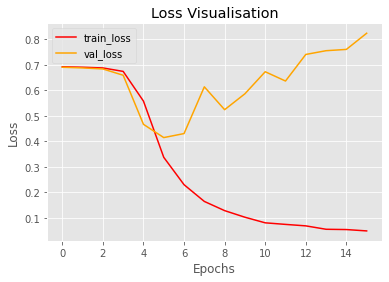

In [587]:
#Epoch vs Loss Plot
from matplotlib import pyplot as plt
plt.plot(hist.history["loss"],color = 'red', label = 'train_loss')
plt.plot(hist.history["val_loss"],color = 'orange', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('BiLSTM1_HASOC_hindi_lossPlot.pdf',dpi=1000)

from google.colab import files
files.download('BiLSTM1_HASOC_hindi_lossPlot.pdf')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

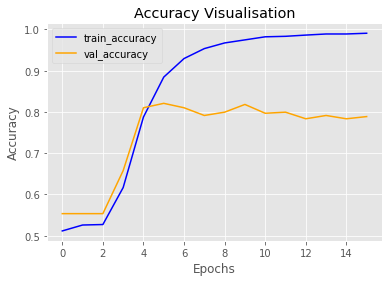

In [588]:

plt.plot(hist.history["accuracy"],color = 'blue', label = 'train_accuracy')
plt.plot(hist.history["val_accuracy"],color = 'orange', label = 'val_accuracy')
plt.title('Accuracy Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('BiLSTM1_HASOC_hindi_accuracyPlot.pdf',dpi=1000)
files.download('BiLSTM1_HASOC_hindi_accuracyPlot.pdf')




In [589]:
#To plot AUC Plot
pred_train = Bi_lstm1_network.predict(padded_clean_text_train) 
pred_test = Bi_lstm1_network.predict(padded_text_test)

In [590]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_AUC_ROC(y_true, y_pred):
    n_classes = 2 #change this value according to class value

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
############################################################################################
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange'])
    #classes_list1 = ["DE","NE","DK"]
    classes_list1 = ["NOT","HOF"]
    for i, color,c in zip(range(n_classes), colors,classes_list1):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (AUC = {1:0.2f})'
                ''.format(c, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    #plt.show()
    plt.savefig('BiLSTM1_HASOC_hindi_Area_RocPlot.pdf',dpi=1000)
    files.download('BiLSTM1_HASOC_hindi_Area_RocPlot.pdf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

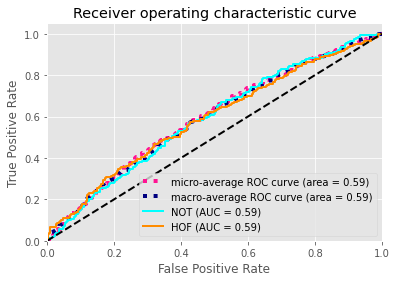

In [591]:
plot_AUC_ROC(label_twoDimension_test,pred_test)

In [592]:

#Self test is incomplete still


ste = ['आप इस खूबसूरत दुनिया से क्यों नफरत कर रहे हैं']

peace = tok_all.texts_to_sequences(ste) #TO ENCODE INTO NUMBER
print(peace)


padded_peace = sequence.pad_sequences(peace, maxlen=maxlen, padding='pre') #tO PADD

self_pred = Bi_lstm1_network.predict_classes(padded_peace).flatten().tolist()


print('Prediction: ',self_pred)
#1 is NOT , 0 is HOF

[[3495, 189, 23, 681]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Prediction:  [1]


#Model 2 - TEXT CNN

In [593]:
embedding_dim = 100
#Embedding_Layer = Embedding(vocabulary_all+1, output_dim = 300, input_length=max_length)
#First layer(s)
#Bi_lstm1_network.add(Embedding_Layer)
CNNmodel = Sequential()
CNNmodel.add(Embedding_Layer)
CNNmodel.add(layers.Conv1D(128, 5, activation='relu'))
CNNmodel.add(layers.GlobalMaxPooling1D())
CNNmodel.add(Dropout(0.3))
CNNmodel.add(layers.Dense(10, activation='relu'))
#CNNmodel.add(Flatten())
CNNmodel.add(layers.Dense(2, activation='sigmoid'))


CNNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(CNNmodel.summary())

"""
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
"""



"""


embed_x = tf.keras.layers.Embedding(input_dim=20000,output_dim=128)(input_x)
embed_x = tf.keras.layers.Dropout(0.5)
tf.keras.layers.Conv1D(filters=128,kernel_size=7,padding='valid',activation='relu',strides=3)(embed_x)
tf.keras.layers.Conv1D(filters=128,kernel_size=7,padding='valid',activation='relu',strides=3)(x)
tf.keras.layers.GlobalMaxPool1D()(x)
tf.keras.layers.Dense(units=1,activation='sigmoid',name='pred')(x)

"""

# Fit model
history = CNNmodel.fit(padded_clean_text_train,label_twoDimension,epochs=20,batch_size=32,callbacks=[earlystopper, reduce_lr],validation_split=0.1)


loss, accuracy = CNNmodel.evaluate(padded_clean_text_train, label_twoDimension, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))


cnnScore = CNNmodel.evaluate(padded_text_test, label_twoDimension_test , verbose=False)
loss, accuracy = CNNmodel.evaluate(padded_text_test, label_twoDimension_test , verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 100, 300)          4419900   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 128)               0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_136 (Dense)            (None, 2)                 22        
Total params: 4,613,340
Trainable params: 4,613,340
Non-trainable params: 0
___________________________________________

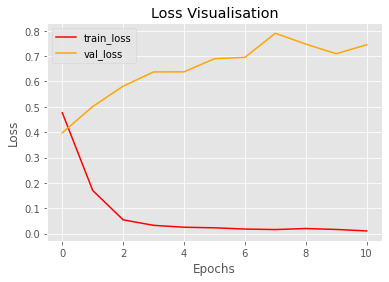

In [594]:

plt.plot(history.history["loss"],color = 'red', label = 'train_loss')
plt.plot(history.history["val_loss"],color = 'orange', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()




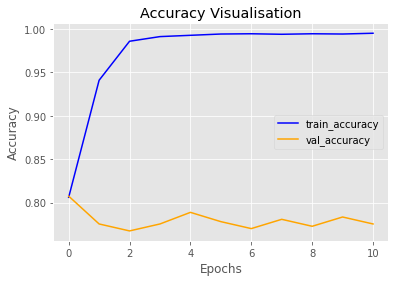

In [595]:
plt.plot(history.history["accuracy"],color = 'blue', label = 'train_accuracy')
plt.plot(history.history["val_accuracy"],color = 'orange', label = 'val_accuracy')
plt.title('Accuracy Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

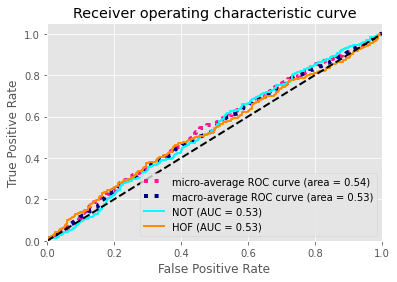

In [596]:
CNNpred_test = CNNmodel.predict(padded_text_test)
plot_AUC_ROC(label_twoDimension_test,CNNpred_test)


In [597]:
CNNpred_t = CNNmodel.predict_classes(padded_text_test).flatten().tolist()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_test, CNNpred_t)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [598]:
ste = ['आप इस खूबसूरत दुनिया से क्यों नफरत कर रहे हैं']
ste_sample = tok_all.texts_to_sequences(ste)
ste_sample = sequence.pad_sequences(ste_sample, padding='pre', maxlen=maxlen)

ste_sample = CNNmodel.predict_classes(ste_sample).flatten().tolist()

print('Prediction: ',ste_sample) #1 is NOT, 0 is HOF

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Prediction:  [1]


#Model 3 - Transformer

In [599]:
vocab_size = vocabulary_all+1  # Only consider the top 20k words
maxlen = 100  # Only consider the first 200 words of each movie review
x_train = sequence.pad_sequences(encoded_text_train, maxlen=maxlen,padding="post",truncating="post")
x_val = sequence.pad_sequences(encoded_text_test, maxlen=maxlen,padding="post",truncating="post")



#(x_train, y_train), (x_val, y_val) = keras.datasets( num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

print(x_train[0])
print(x_val[0])

y_train = label_twoDimension
y_val = label_twoDimension_test


print(f"Shape of train {x_train.shape}")
print(f"Shape of test {x_val.shape}")

3732 Training sequences
933 Validation sequences
[1447    5  217 3999   83 6243 2342  747 6244 1039 6245    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[  21  418 1270  515   28 2245 1271 2246    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

In [600]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Embedding

# Implement multi head self attention as a Keras layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [601]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [602]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [603]:
# Create classifier model using transformer layer
embed_dim = 100 # defined above  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [604]:
from keras import metrics
model.compile("adam", "binary_crossentropy", metrics=["accuracy", metrics.FalsePositives(), metrics.FalseNegatives()])
model.summary()
civix = model.fit(padded_clean_text_train,label_twoDimension, epochs=5)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
token_and_position_embedding (None, 100, 100)          1483300   
_________________________________________________________________
transformer_block_15 (Transf (None, 100, 100)          47332     
_________________________________________________________________
global_average_pooling1d_13  (None, 100)               0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 20)                2020      
_________________________________________________________________
dropout_101 (Dropout)        (None, 20)                0  

In [605]:
pred_soft = model.predict(padded_text_test)

In [609]:
score = model.evaluate(padded_clean_text_train, label , verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

tranScore = model.evaluate(padded_text_test, label_test , verbose=False)
lossTrans, accuracyTrans = model.evaluate(padded_text_test, label_test , verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ValueError: ignored

In [ ]:
pred = np.where(pred_soft > 0.50, 1, 0)

acc = accuracy_score(pred, test_labels)
f1 = f1_score(pred, test_labels)

cm = confusion_matrix(test_labels, pred)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]

print('Accuracy score: {:.4f}'.format(acc), 'F1 score: {:.4f}'.format(f1))
print('False Positives: {:.0f}'.format(fp), 'False Negatives: {:.0f}'.format(fn))
print('Confusion matrix:\n', cm)